### **This notebook explores data from user sessions from a travel start-up TravelTide.**  
#### The purpose is to develope user segments for a marketing rewarding program

In [63]:
import os
import importlib

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from customer_segmentation.utils import functions

importlib.reload(functions)

# Set pandas to display all columns
pd.set_option("display.max_columns", None)

### **Query data**

In [64]:
cohort = functions.read_from_db("customer_data_model")

display(cohort.shape)
display(pd.DataFrame({"dtypes": cohort.dtypes}).T)
cohort.head(3)

(172355, 32)

,user_id,age,has_children,is_married,cnt_trips,cnt_cancellations,avg_diff_trip_days,days_last_trip,avg_days_advance_booking,avg_travel_days,avg_seats,avg_checked_bags,avg_flight_travel_days,sum_flight_price,avg_distance_km,sum_distance_km,avg_rooms,avg_hotel_nights,sum_hotel_price,min_signup_date,cnt_sessions,sum_page_clicks,days_active,avg_session_duration_seconds,flight_booked,hotel_booked,sum_flight_discount,sum_hotel_discount,cnt_flight_discount,cnt_hotel_discount,avg_flight_discount,avg_hotel_discount
dtypes,int64,int64,int64,int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,float64,int64,int64,float64,float64,int64,int64,float64,float64


,user_id,age,has_children,is_married,cnt_trips,cnt_cancellations,avg_diff_trip_days,days_last_trip,avg_days_advance_booking,avg_travel_days,avg_seats,avg_checked_bags,avg_flight_travel_days,sum_flight_price,avg_distance_km,sum_distance_km,avg_rooms,avg_hotel_nights,sum_hotel_price,min_signup_date,cnt_sessions,sum_page_clicks,days_active,avg_session_duration_seconds,flight_booked,hotel_booked,sum_flight_discount,sum_hotel_discount,cnt_flight_discount,cnt_hotel_discount,avg_flight_discount,avg_hotel_discount
0,264579,26,0,0,2.0,0.0,26.0,247,8.0,4.0,1.0,1.0,4.0,153.15,877.0,1754.0,1.0,3.0,3291.0,2022-07-28,8,140,273,129.0,2,2,0.0,0.0,1,2,0.15,0.13
1,264581,21,1,0,1.0,0.0,0.0,335,5.0,8.0,0.0,0.0,0.0,0.00,0.0,0.0,1.0,8.0,1320.0,2022-07-28,7,59,347,63.0,0,1,0.0,66.0,3,3,0.13,0.08
2,264582,42,0,1,3.0,0.0,107.0,110,7.0,4.0,1.0,0.0,4.0,696.83,2533.0,7599.0,1.0,3.0,1595.0,2022-07-28,7,205,323,216.0,3,3,0.0,0.0,1,1,0.15,0.10


### **Preprocessing**

In [65]:
# convert data types
cohort["user_id"] = cohort["user_id"].astype(str)
cohort["min_signup_date"] = pd.to_datetime(cohort["min_signup_date"])

**Create meaningful features**

In [66]:
# activity & engagement
cohort["month_active"] = cohort["days_active"] / 30
cohort["sessions_per_month"] = cohort["cnt_sessions"] / cohort["month_active"]
cohort["trips_per_month"] = cohort["cnt_trips"] / cohort["month_active"]
cohort["page_click_per_session"] = cohort["sum_page_clicks"] / cohort["cnt_sessions"]
# cohort['trips_per_session'] = cohort['cnt_trips'] / cohort['cnt_sessions'] # redundant with trips_per_month

# bookings & cancellations
cohort["total_booking_value"] = cohort["sum_hotel_price"] + cohort["sum_flight_price"]
cohort["avg_booking_value"] = (
    cohort["total_booking_value"] / cohort["cnt_trips"]
)  # -> input feature for clustering
cohort["customer_value_per_month"] = (
    cohort["total_booking_value"]
    / cohort["month_active"]  # -> important for RFM analysis
)
cohort["cancellation_rate"] = cohort["cnt_cancellations"] / cohort["cnt_trips"]

# discounts
cohort["total_discount_rate"] = round(
    (cohort["sum_flight_discount"] + cohort["sum_hotel_discount"])
    / cohort["total_booking_value"],
    2,
)
cohort["discount_per_km"] = cohort["sum_flight_discount"] / cohort["sum_distance_km"]
cohort["flight_discount_rate"] = cohort["cnt_flight_discount"] / cohort["flight_booked"]
cohort["hotel_discount_rate"] = cohort["cnt_hotel_discount"] / cohort["hotel_booked"]

**Data clean-up**

In [67]:
# check features with missing data
display(functions.missing_data(cohort))

,Total,Percentage
discount_per_km,36365,21.098895
total_discount_rate,22274,12.923327
cancellation_rate,22273,12.922747
avg_booking_value,22273,12.922747
hotel_discount_rate,13056,7.575063
flight_discount_rate,12154,7.051725


In [68]:
# handle inf and na values
cohort = cohort.replace([np.inf, -np.inf], 0).fillna(0)

**Check some metrics**

In [72]:
share_user_not_booked = (
    cohort[cohort["cnt_trips"] == 0]["user_id"].nunique() / cohort["user_id"].nunique()
)
print(f"Percent share of users without bookings: {share_user_not_booked * 100:.1f}%")

high_booking_values = (
    cohort[(cohort["avg_booking_value"] >= 5000) & (cohort["cnt_trips"] > 0)][
        "user_id"
    ].nunique()
    / cohort["user_id"].nunique()
)
print(
    f"Percent share of users with high booking values: {high_booking_values * 100:.1f}%"
)
flight_discount_rate = np.mean(cohort["flight_discount_rate"])
print(
    f"Percent share of users using flight discounts: {flight_discount_rate * 100:.1f}%"
)
hotel_discount_rate = np.mean(cohort["hotel_discount_rate"])
print(f"Percent share of users using hotel discounts: {hotel_discount_rate * 100:.1f}%")
cancellation_rate = np.mean(cohort["cancellation_rate"])
print(f"Percent share of cancellations: {cancellation_rate * 100:.1f}%")

Percent share of users without bookings: 12.9%
Percent share of users with high booking values: 1.2%
Percent share of users using flight discounts: 51.5%
Percent share of users using hotel discounts: 40.8%
Percent share of cancellations: 1.2%


**Remove absolute and redundant metrics**

In [73]:
# remove columns not necessary for further analysis
columns_to_drop = [
    "cnt_flight_discount",
    "cnt_hotel_discount",
    "cnt_cancellations",
    "cnt_sessions",
    "cnt_trips",
    "sum_distance_km",
    "sum_flight_discount",
    "sum_flight_price",
    "sum_hotel_discount",
    "sum_hotel_price",
    "total_booking_value",
    "sum_page_clicks",
    "days_active",
]
cohort = cohort.drop(columns=columns_to_drop)

In [74]:
# list all metrics
binary_cols = functions.get_binary_columns(cohort)
numeric_cols = cohort.select_dtypes(include=[np.number]).columns.drop(binary_cols)
sorted(numeric_cols.to_list())

['age',
 'avg_booking_value',
 'avg_checked_bags',
 'avg_days_advance_booking',
 'avg_diff_trip_days',
 'avg_distance_km',
 'avg_flight_discount',
 'avg_flight_travel_days',
 'avg_hotel_discount',
 'avg_hotel_nights',
 'avg_rooms',
 'avg_seats',
 'avg_session_duration_seconds',
 'avg_travel_days',
 'cancellation_rate',
 'customer_value_per_month',
 'days_last_trip',
 'discount_per_km',
 'flight_booked',
 'flight_discount_rate',
 'hotel_booked',
 'hotel_discount_rate',
 'month_active',
 'page_click_per_session',
 'sessions_per_month',
 'total_discount_rate',
 'trips_per_month']

In [75]:
# list binaries
sorted(binary_cols)

['has_children', 'is_married']

### **Explore distributions**

In [76]:
cohort[numeric_cols].describe().T.style.background_gradient(cmap="Blues")

,count,mean,std,min,25%,50%,75%,max
age,172355.000000,41.059731,12.888147,18.000000,32.000000,40.000000,49.000000,90.000000
avg_diff_trip_days,172355.000000,29.790148,35.618342,0.000000,0.000000,22.000000,46.000000,328.000000
days_last_trip,172355.000000,76.665562,61.290080,0.000000,29.000000,65.000000,113.000000,357.000000
avg_days_advance_booking,172355.000000,10.531856,17.943291,0.000000,6.000000,8.000000,9.000000,337.000000
avg_travel_days,172355.000000,4.653535,3.611238,0.000000,3.000000,4.000000,6.000000,78.000000
avg_seats,172355.000000,0.967463,0.681070,0.000000,1.000000,1.000000,1.000000,11.000000
avg_checked_bags,172355.000000,0.531589,0.603929,0.000000,0.000000,0.000000,1.000000,10.000000
avg_flight_travel_days,172355.000000,3.655960,3.236634,0.000000,2.000000,3.000000,5.000000,49.000000
avg_distance_km,172355.000000,1831.839216,1812.462572,0.000000,544.000000,1710.000000,2540.000000,19208.000000
avg_rooms,172355.000000,1.017313,0.615631,0.000000,1.000000,1.000000,1.000000,6.000000


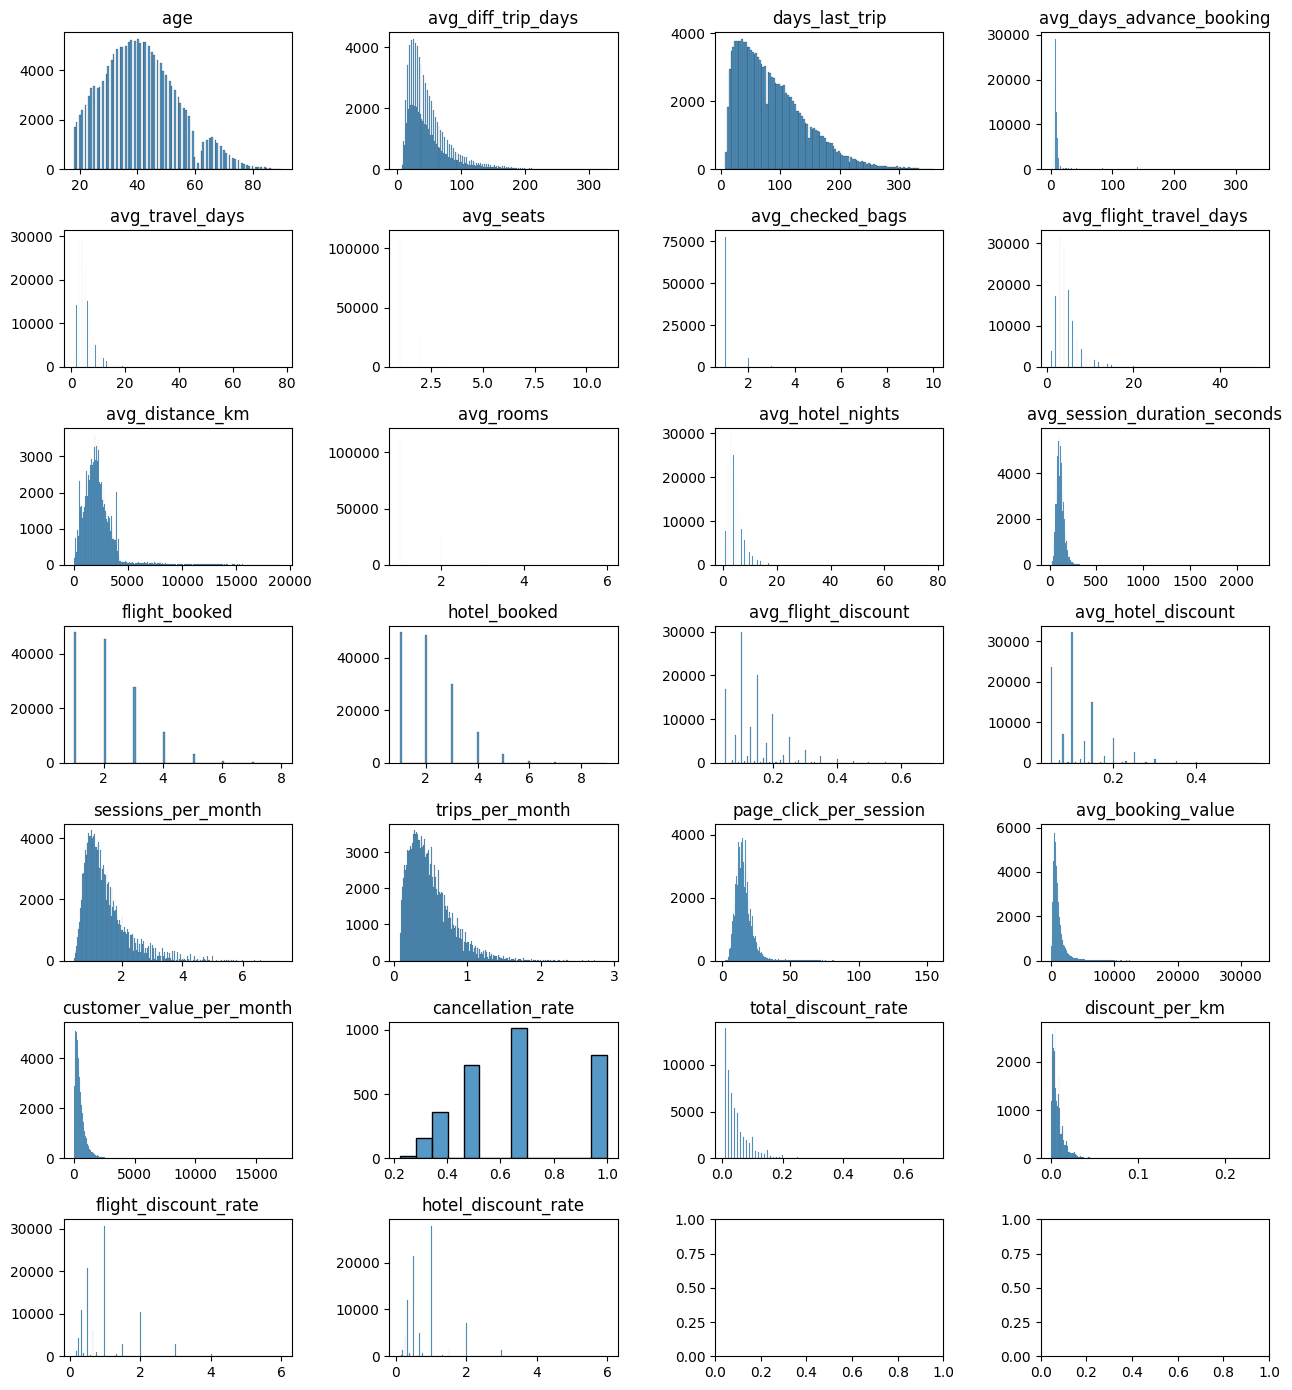

In [ ]:
functions.plot_univariate_series(
    df=cohort,
    metrics=numeric_cols.to_list(),
    n_cols=4,
    plot_type=sns.histplot,
)

**Aggregated values per first session per user**

In [ ]:
# aggregate by sign up date
user_grouped_per_min_date = (
    cohort.groupby(["min_signup_date"])
    .agg(
        cnt_user=("user_id", "nunique"),
        month_active=("month_active", "mean"),
        avg_diff_days=("avg_diff_trip_days", "mean"),
        discount_rate=("total_discount_rate", "sum"),
        discount_per_km=("discount_per_km", "mean"),
        cancellation_rate=("cancellation_rate", "mean"),
        avg_booking_value=("avg_booking_value", "mean"),
        days_last_trip=("days_last_trip", "sum"),
        avg_travel_days=("avg_travel_days", "mean"),
        trips_per_month=("trips_per_month", "mean"),
        sessions_per_month=("sessions_per_month", "mean"),
        page_click_per_session=("page_click_per_session", "mean"),
    )
    .reset_index()
)

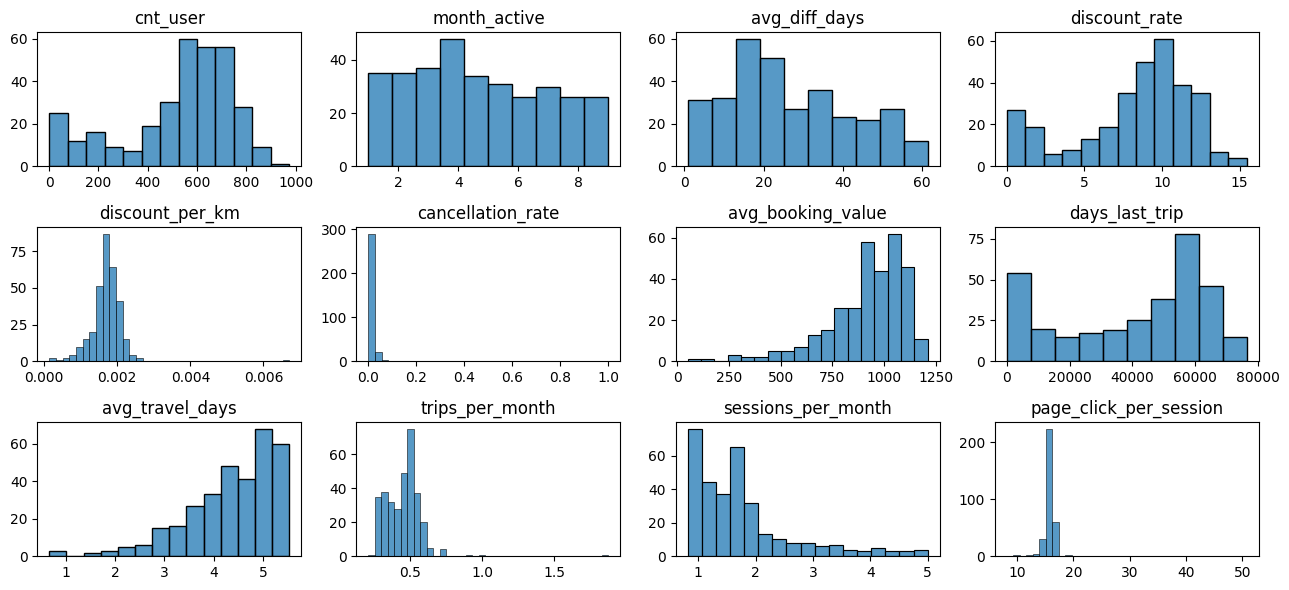

In [82]:
metrics = user_grouped_per_min_date.select_dtypes(include=[np.number]).columns.to_list()

functions.plot_univariate_series(
    df=user_grouped_per_min_date, metrics=metrics, n_cols=4, plot_type=sns.histplot
)

**discover user pattern over time**  
 
- activity decreases overall over time  
- average duration between last booking and last session is stable

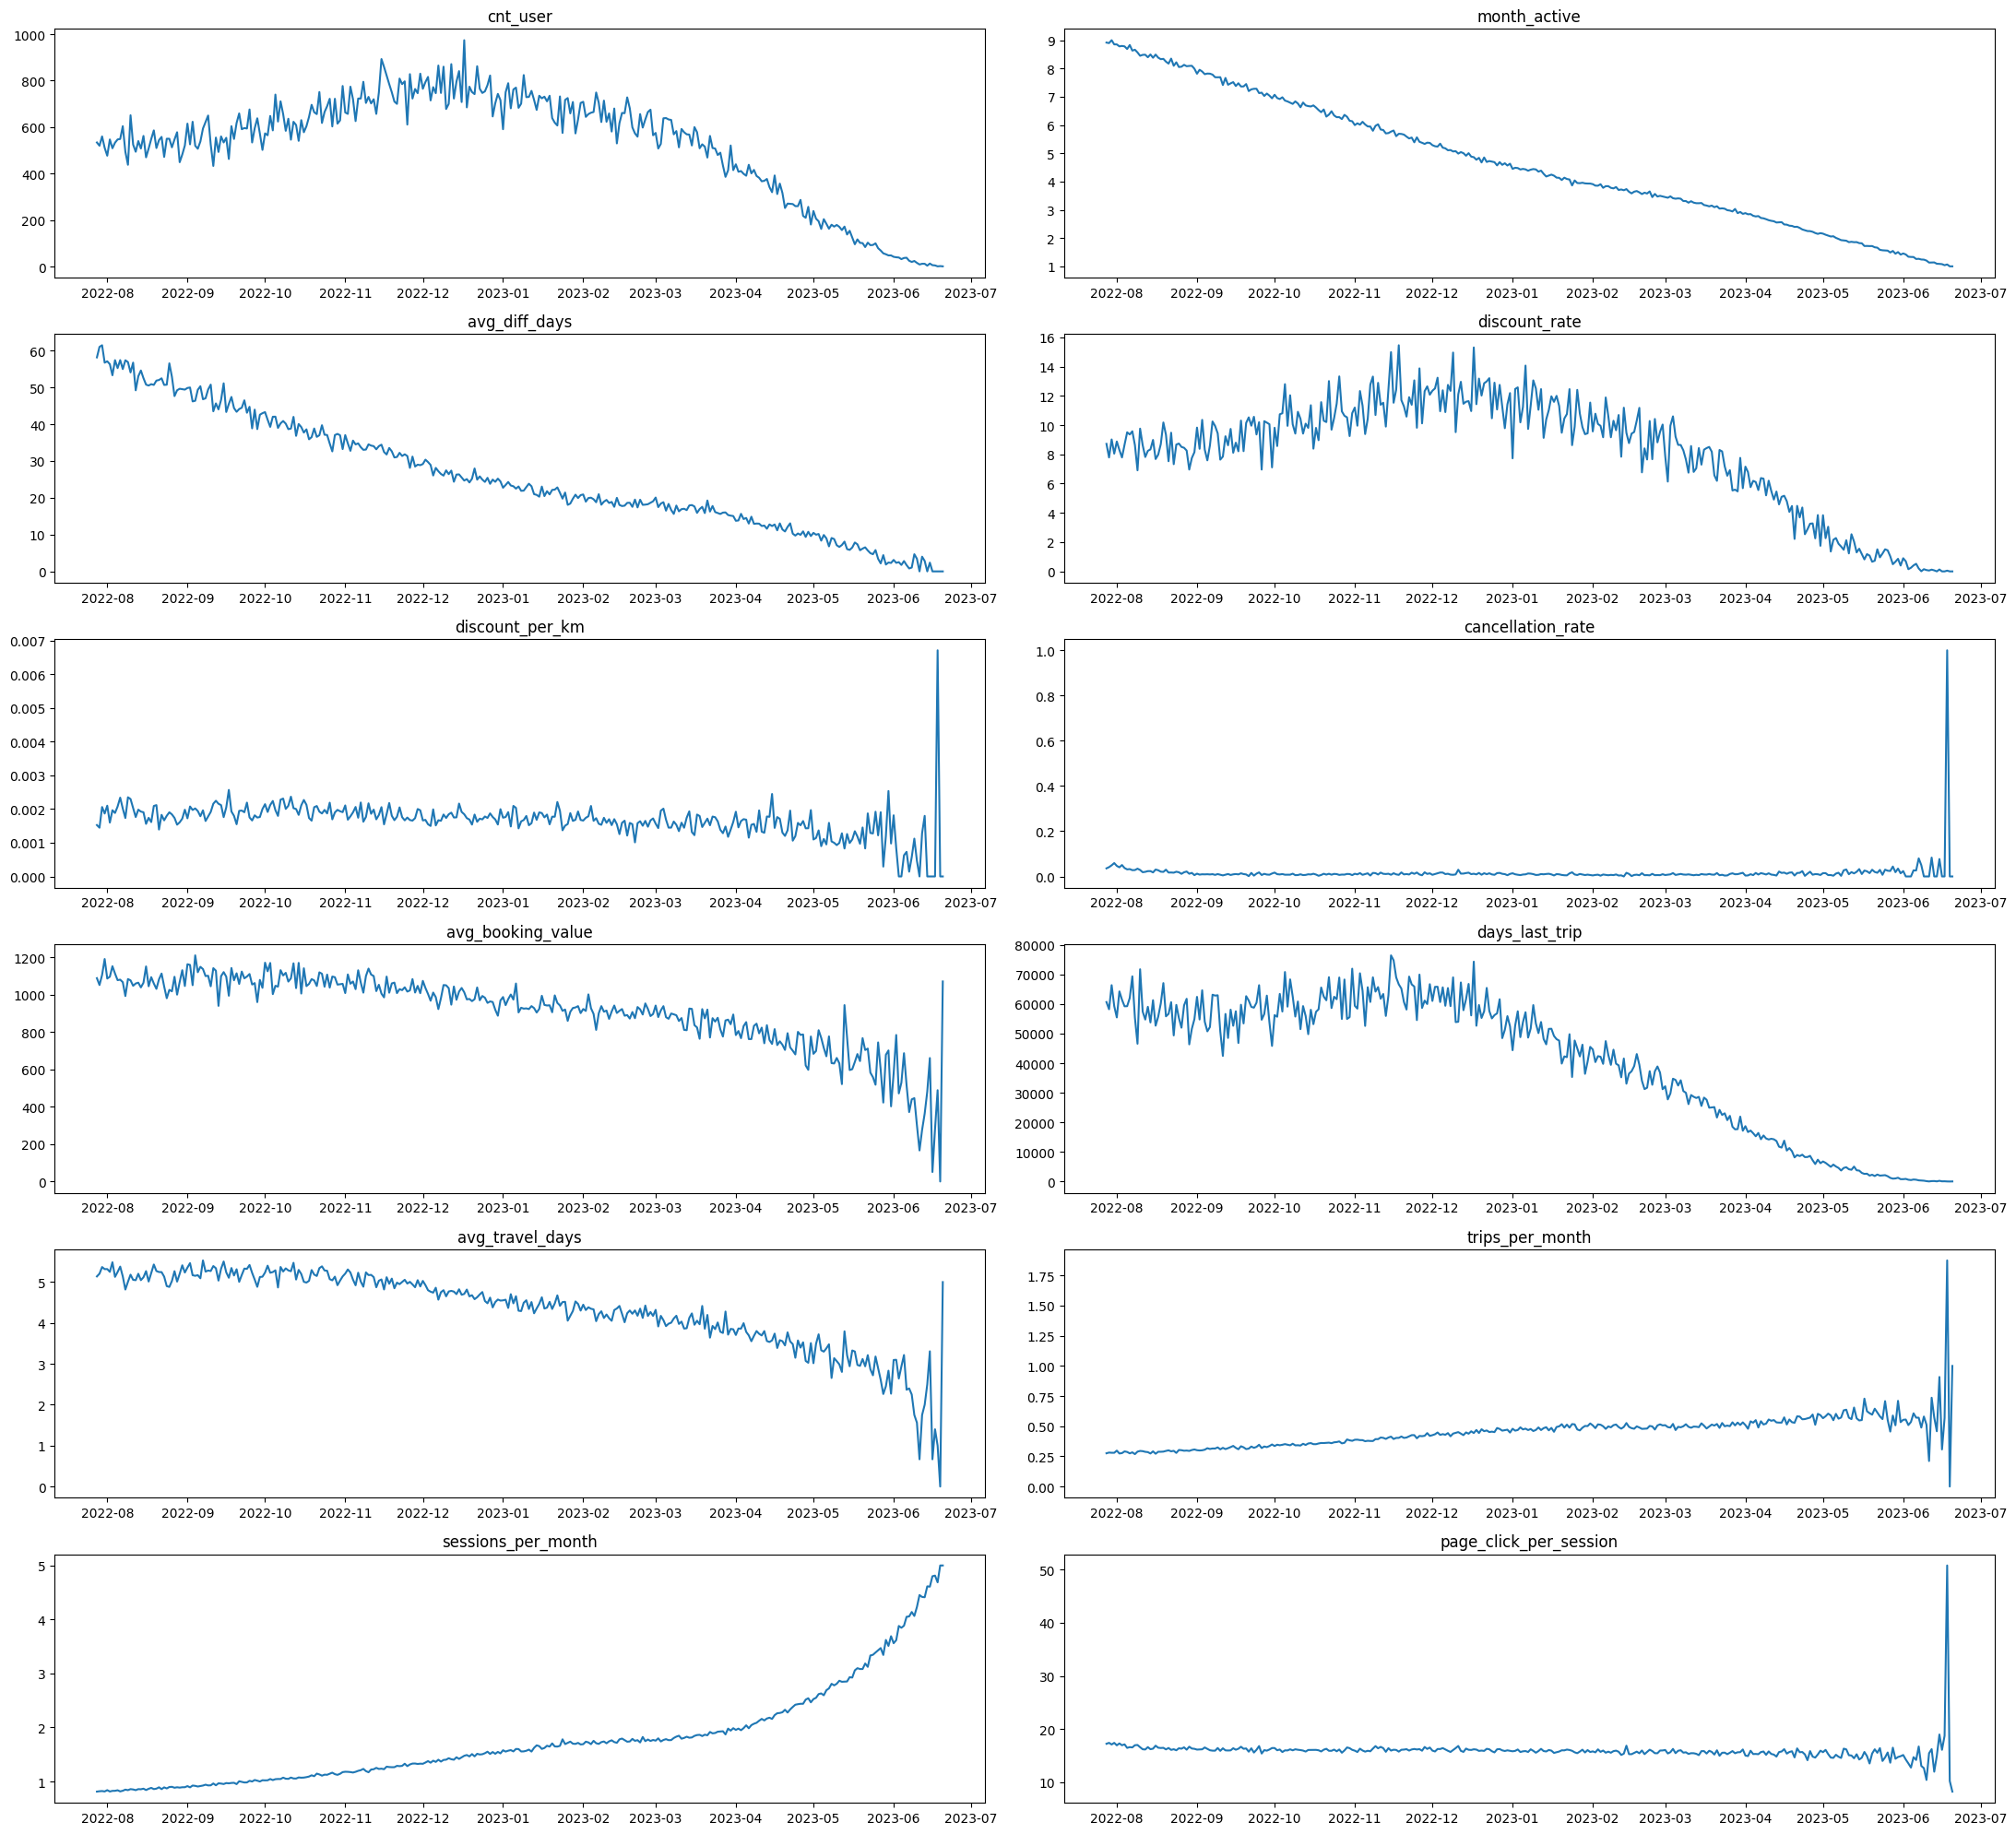

In [83]:
functions.plot_time_series(
    df=user_grouped_per_min_date,
    x=user_grouped_per_min_date.columns.values[0],
    y=list(user_grouped_per_min_date.columns.values[1:]),
)

### **Export cleaned data for RFM & Segmentation**

In [86]:
# export data to csv file

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, os.path.pardir, "data")
data_path = os.path.join(data_dir, "cohort_data.csv")
cohort.to_csv(data_path, index=False)